<a href="https://colab.research.google.com/github/bilzard/aws-sam-localstack-example/blob/master/002_optimum_portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# はじめに

このnotebook では[CVXOPT]を使ってポートフォリオの配分を最適化します。


[CVXOPT]: https://cvxopt.org/

In [ ]:
%%HTML
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

In [ ]:
# Google Colab環境ではGoogle Driveをマウントしてアクセスできるようにします。
import sys

if 'google.colab' in sys.modules:
    # Google Drive をマウントします
    from google.colab import drive
    mount_dir = "/content/drive"
    drive.mount(mount_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ライブラリのバージョンを調整します
!pip install --no-cache-dir joblib==1.0.1 numpy==1.19.5 pandas==1.1.5 scikit-learn==0.20.3 scipy==1.2.1 seaborn==0.9.0

     |████████████████████████████████| 24.8MB 1.4MB/s 
     |████████████████████████████████| 215kB 43.0MB/s 
ERROR: phik 0.11.2 has requirement scipy>=1.5.2, but you'll have scipy 1.2.1 which is incompatible.
ERROR: pandas-profiling 2.11.0 has requirement scipy>=1.4.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: pandas-profiling 2.11.0 has requirement seaborn>=0.10.1, but you'll have seaborn 0.9.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.6.2
    Uninstalling scipy-1.6.2:
      Successfully uninstalled scipy-1.6.2
  Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


In [ ]:
import io
import os
import sys
import zipfile

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from scipy import stats
from IPython.core.magic import register_cell_magic

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


作業ディレクトリを指定します。自分の環境に合わせて適宜設定してください。

In [ ]:
PROJECT_DIR = f'{mount_dir}/MyDrive/JPX_competition/sub001'

In [ ]:
# インポート時にエラーが出た場合は、以下のmodule_dirをbacktest.pyを配置したディレクトリに変更してください。
import sys
if 'google.colab' in sys.modules:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = f"{mount_dir}/MyDrive/JPX_competition/Chapter03/backtest"
else:
  # Backtestを配置したディレクトリへのフルパスを指定します
  module_dir = "/notebook/Chapter03/backtest" 
sys.path.append(module_dir)

from backtest import Backtest

In [ ]:
# 表示用の設定を変更します
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

In [ ]:
# データセットを配置したディレクトリのパスを設定
if 'google.colab' in sys.modules:
    dataset_dir = f"{mount_dir}/MyDrive/JPX_competition/data_dir_comp2"
else:
    dataset_dir = "/notebook/data_dir_comp2"

In [ ]:
# 入力パラメーターを設定します。ランタイム環境での実行時と同一フォーマットにします
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
}

In [ ]:
# 投資対象日付を指定します
start_dt = pd.Timestamp("2020-01-01")

In [ ]:
if "purchase_date" in inputs.keys():
    # ランタイム環境では指定された投資対象日付を使用します
    # purchase_dateを読み込み
    df_purchase_date = pd.read_csv(inputs["purchase_date"])
    # purchase_dateの最も古い日付を投資対象日付として使用します
    start_dt = pd.Timestamp(df_purchase_date.sort_values("Purchase Date").iloc[0, 0])

In [ ]:
# 銘柄情報読み込み
df_stock_list = pd.read_csv(inputs["stock_list"])
# 問題2のユニバース (投資対象の条件を満たす銘柄群) 取得
codes = df_stock_list.loc[
    df_stock_list.loc[:, "universe_comp2"] == True, "Local Code"
].unique()

In [ ]:
# 価格情報読み込み、インデックス作成
df_price = pd.read_csv(inputs["stock_price"]).set_index("EndOfDayQuote Date")
# 日付型に変換
df_price.index = pd.to_datetime(df_price.index, format="%Y-%m-%d")

In [208]:
df_price

,Local Code,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
EndOfDayQuote Date,,,,,,,,,,,,,,,
2019-11-18,1301,2941.0,2941.0,2923.0,2935.0,2935.0,14200.0,1.0,2923.0,2019/11/15,2923.0,2019/11/15,12.0,0.411,2932.923
2019-11-19,1301,2930.0,2948.0,2926.0,2938.0,2938.0,12800.0,1.0,2935.0,2019/11/18,2935.0,2019/11/18,3.0,0.102,2937.367
2019-11-20,1301,2939.0,2939.0,2883.0,2895.0,2895.0,35700.0,1.0,2938.0,2019/11/19,2938.0,2019/11/19,-43.0,-1.464,2905.938
2019-11-21,1301,2908.0,2910.0,2873.0,2902.0,2902.0,17600.0,1.0,2895.0,2019/11/20,2895.0,2019/11/20,7.0,0.242,2893.426
2019-11-22,1301,2905.0,2909.0,2886.0,2893.0,2893.0,25300.0,1.0,2902.0,2019/11/21,2902.0,2019/11/21,-9.0,-0.310,2896.407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,9997,995.0,1037.0,995.0,1025.0,1025.0,332300.0,1.0,980.0,2020/12/23,980.0,2020/12/23,45.0,4.592,1022.925
2020-12-25,9997,1018.0,1072.0,1018.0,1065.0,1065.0,426200.0,1.0,1025.0,2020/12/24,1025.0,2020/12/24,40.0,3.902,1048.806
2020-12-28,9997,1080.0,1096.0,1050.0,1072.0,1072.0,391400.0,1.0,1065.0,2020/12/25,1065.0,2020/12/25,7.0,0.657,1073.684


In [ ]:
# 投資対象日の前週金曜日時点で予測を出力するため、予測出力用の日付を設定します。
pred_start_dt = pd.Timestamp(start_dt) - pd.Timedelta("3D")
# 特徴量の生成に必要な日数をバッファとして設定
n = 30
# データ絞り込み日付設定
data_start_dt = pred_start_dt - pd.offsets.BDay(n)
# 日付で絞り込み
filter_date = df_price.index >= data_start_dt
# 銘柄をユニバースで絞り込み
filter_universe = df_price.loc[:, "Local Code"].isin(codes)
# 絞り込み実施
df_price = df_price.loc[filter_date & filter_universe]

直感的に理解しやすい日付 x 銘柄のテーブルを作ります。

In [ ]:
df_per_instruments = pd.pivot_table(df_price, values=['EndOfDayQuote Close'], columns=['Local Code'], index='EndOfDayQuote Date', aggfunc='mean')

扱いにくいmulti index をバラします

In [ ]:
df_per_instruments.columns = df_per_instruments.columns.droplevel(level=0)

# 異常値の除外

なぜか 2020-10-01 のデータがすべてゼロになっているので、このレコードを除外します。（おそらくランタイム環境でも外れ値を除外する処理が必要になる）

In [ ]:
# 外れ値（終値が0以下）を除外
filter_outlier = df_per_instruments.iloc[:, 0] > 0
df_per_instruments = df_per_instruments[filter_outlier]

週次リターンを求めます。値が存在しないデータは0で補完します。

In [ ]:
df_return = df_per_instruments.pct_change(7).fillna(0)

マーケットのリターンを求めます。ここでは全銘柄のリターンの中央値をマーケットのリターンとします。

In [ ]:
# universe
df_universe = df_return.median(axis=1)

各銘柄のリターンからマーケットのリターンを引いた、マーケット調整済みリターンを求めます。

In [ ]:
df_return_mka = df_return.apply(lambda x: x - df_universe)

無限大は扱いにくいので nan に置換します

In [ ]:
df_return_mka.replace([np.inf, -np.inf], np.nan, inplace=True)

2020年3月のデータはコロナ禍による影響が含まれていると考えられるため、全区間で平均を計算すると、直近の状況を正しく反映していない可能性があります。コロナ禍の影響が落ち着いてきた4月以降のデータのみでフィルタリングします。

In [ ]:
# 2020年 4 月以降に限定
filter_date = df_return_mka.index.to_series().between('2020-04-01', '2021-01-01')

コンペの課題では、月曜日に買って金曜日に売るという売り買いの仕方が決まっているので、金曜日のデータに限定します。
チュートリアルでも触れているように、機関投資家が金曜日にまとめて売却する、といった運用をするなど、曜日に特徴的な影響がある可能性があります。
ここではその影響を見ます。

In [ ]:
# 2020年 4 月以降に限定
filter_date = df_return_mka.index.to_series().between('2020-04-01', '2021-01-01')
filter_day_of_week = df_return_mka.index.dayofweek == 4 # 金曜日

リターンが大きい銘柄は、ボラティリティ（標準偏差）も大きい傾向にあります。
ポートフォリオを組むさいは、ボラが大きすぎる銘柄はリスクも大きいので、この値も重要となります。
平均値をボラティリティで割った値（SHARPE ratio）も求めます。

In [ ]:
df_ = pd.concat([
    df_return[filter_date].replace([np.inf, -np.inf], np.nan).mean(),
    df_return[filter_date].replace([np.inf, -np.inf], np.nan).std(),
    df_return_mka[filter_date].replace([np.inf, -np.inf], np.nan).mean(),
    df_return_mka[filter_date].replace([np.inf, -np.inf], np.nan).std(),
], axis=1)
df_.columns = ['return_7_mean', 'return_7_std', 'mka_return_7_mean', 'mka_return_7_std']
df_['SHARPE'] = df_['mka_return_7_mean'] / df_['mka_return_7_std']

In [ ]:
df_.sort_values('mka_return_7_mean', ascending=False, inplace=True)

In [ ]:
df_instrument = pd.merge(
    df_.replace([np.inf, -np.inf], np.nan).sort_values('return_7_mean', ascending=False),
    df_stock_list.set_index('Local Code')[['Name (English)', '33 Sector(name)']],
    right_index=True,
    left_index=True,
    how='left'
)

# リスクーリターンカーブ

リスクーリターンカーブを確認します。ポートフォリオを組むときは、同じリスクだとリターンの大きい銘柄を選択するほうが合理的です。理想的にはこのグラフの左上の端に近い銘柄で分散投資を組むのが良いと思われます。

「左上に近い」という条件をどうアルゴリズムに落とすかは選択肢がいくつかあります。
ぱっと思いつくのはRiskとReturnを二次元のメッシュに切り、各リスクのメッシュに対してリターンが最大のメッシュにある銘柄を選択するなど。

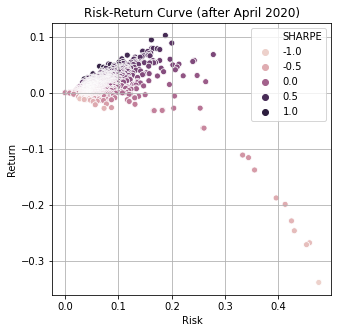

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x='return_7_std', y='return_7_mean', data=df_instrument, ax=ax, hue='SHARPE')
ax.set_title('Risk-Return Curve (after April 2020)')
ax.set_xlabel('Risk')
ax.set_ylabel('Return')
ax.grid(True)

In [ ]:
df_instrument.head(25).index

Int64Index([4477, 2150, 3998, 6095, 6070, 3788, 3663, 3962, 4308, 2484, 4488, 6937, 3902, 3633, 2375, 4490, 4436, 3491,
            3696, 9519, 3031, 3922, 2158, 4772, 3558],
           dtype='int64', name='Local Code')

# 銘柄どうしの相関

ポートフォリオを組むさいは、銘柄どうしの相関が小さいほうがリスクを小さくできるので、相関をみておきます。

ここでは、SHARPEが大きい上位25銘柄でポートフォリオを組むものとして、これらの銘柄の相関係数をヒートマップにします。

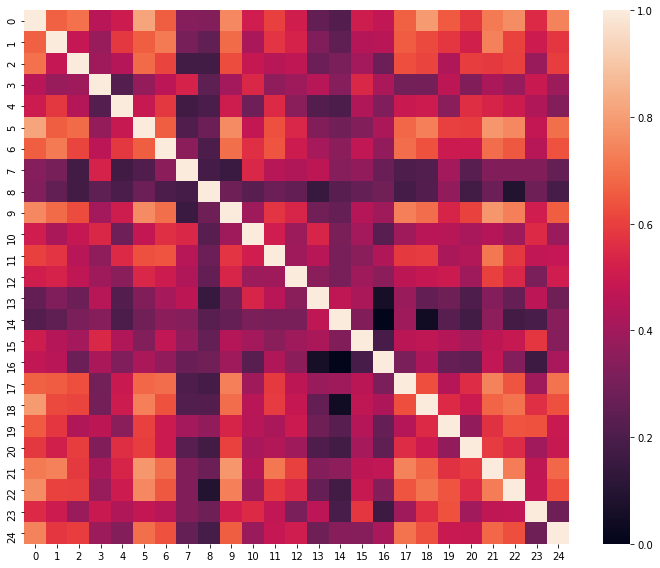

In [262]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
sns.heatmap(np.corrcoef(df_return.loc[:,list(df_instrument.sort_values('SHARPE', ascending=False).head(25).index)].T), ax=ax, vmin=0, vmax=1)
plt.tight_layout()

25銘柄の中でも相関の大きいものと小さいものがあるので、ポートフォリオを組むことでリスクが小さくなることが期待できそうです。
もう少し工夫すると、この中からさらに相関の小さいものどうしで組んだり、リターンの大きいものどうしで組むをなどの方針が考えられます。

# 最適なポートフォリオの構成比について

マコービッツの平均分散モデル[1]を使ってある期待収益を達成しながら、リスクを最小化する問題を解きます。最適化のコードは資料[1]のものを流用させていただきました。

[1] [Pythonでポートフォリオ最適化（マーコビッツの平均分散モデル）- Qiita](https://qiita.com/yumaloop/items/d709cc9b43f18df70382)

In [210]:
# source: https://qiita.com/yumaloop/items/d709cc9b43f18df70382
import cvxopt

def cvxopt_qp_solver(r, r_e, cov):
    # CVXOPT QP Solver for Markowitz' Mean-Variance Model
    # See https://cvxopt.org/userguide/coneprog.html#quadratic-programming
    # See https://cdn.hackaday.io/files/277521187341568/art-mpt.pdf
    n = len(r)
    r = cvxopt.matrix(r)

    P = cvxopt.matrix(2.0 * np.array(cov))
    q = cvxopt.matrix(np.zeros((n, 1)))
    G = cvxopt.matrix(np.concatenate((-np.transpose(r), -np.identity(n)), 0))
    h = cvxopt.matrix(np.concatenate((-np.ones((1,1)) * r_e, np.zeros((n,1))), 0))
    A = cvxopt.matrix(1.0, (1, n))
    b = cvxopt.matrix(1.0)    
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    return sol

最適化の結果、比率が低すぎてほぼ選択されていないのと同様の銘柄ができるため、SHARPEの大きい75銘柄から構成します。
期待収益は 5% としました。

In [317]:
df_portfolio = df_return.loc[:,list(df_instrument.sort_values('SHARPE', ascending=False).head(75).index)]

In [354]:
def optimize_portfolio(df_portfolio, r_e=.05):
  r = df_portfolio.mean().values # Expected returns
  r_e = r_e # Lower bound for portfolio's return
  cov = df_portfolio.cov() # Covariance matrix

  # Solve QP and derive optimal portfolio
  sol = cvxopt_qp_solver(r, r_e, cov)
  x_opt = np.array(sol['x'])

  exp_return = np.inner(x_opt.ravel(), r)
  var_return = sol["primal objective"]

  return x_opt, exp_return, var_return

In [355]:
x_opt, exp_return, var_return = optimize_portfolio(df_portfolio, r_e=.05)

print(f'Expected return: {exp_return:5.5f}:')
print(f'Variance of return: {var_return:5.5f}')

     pcost       dcost       gap    pres   dres
 0:  3.3270e-03 -9.7027e-01  8e+01  9e+00  9e+00
 1:  3.7823e-03 -9.4521e-01  4e+00  3e-01  3e-01
 2:  4.0299e-03 -7.8298e-01  3e+00  2e-01  2e-01
 3:  8.3407e-03 -5.5490e-01  9e-01  2e-02  2e-02
 4:  9.0552e-03 -1.1769e-01  1e-01  1e-16  4e-15
 5:  8.7153e-03 -5.4163e-03  1e-02  2e-16  9e-16
 6:  7.0781e-03  2.5985e-03  4e-03  2e-16  2e-16
 7:  5.4038e-03  2.1851e-03  3e-03  2e-16  3e-16
 8:  4.8953e-03  4.3061e-03  6e-04  3e-16  1e-14
 9:  4.7031e-03  4.4567e-03  2e-04  1e-16  4e-15
10:  4.5659e-03  4.5439e-03  2e-05  8e-17  3e-15
11:  4.5517e-03  4.5514e-03  3e-07  4e-16  3e-15
12:  4.5515e-03  4.5515e-03  3e-09  8e-17  9e-15
Optimal solution found.
Expected return: 0.05000:
Variance of return: 0.00455


期待収益が5%に対して、リスクは 0.455% とかなり小さくなりました。実際の構成比を可視化してみます。

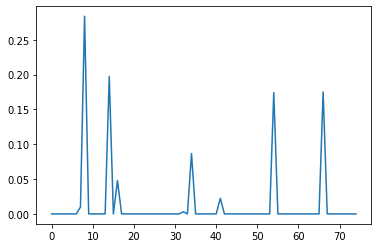

In [356]:
plt.plot(x_opt)

比率が1%未満のものをのぞくと、7銘柄でポートフォリオを組んでいます。

ランタイム環境では5銘柄以上を選択しないと失格となるため、4銘柄以下だった場合の対応が必要です。

## 期待収益の最適化

期待収益をパラメータとみなして変化させて、期待収益とリスクの関係をプロットしてみます。

In [335]:
portfolios = []

for r_e in np.linspace(0.05, 0.07, 10):
  x_opt, exp_return, var_return = optimize_portfolio(df_portfolio, r_e=r_e)
  portfolios.append((x_opt, exp_return, var_return, r_e))

     pcost       dcost       gap    pres   dres
 0:  3.3270e-03 -9.7027e-01  8e+01  9e+00  9e+00
 1:  3.7823e-03 -9.4521e-01  4e+00  3e-01  3e-01
 2:  4.0299e-03 -7.8298e-01  3e+00  2e-01  2e-01
 3:  8.3407e-03 -5.5490e-01  9e-01  2e-02  2e-02
 4:  9.0552e-03 -1.1769e-01  1e-01  1e-16  4e-15
 5:  8.7153e-03 -5.4163e-03  1e-02  2e-16  9e-16
 6:  7.0781e-03  2.5985e-03  4e-03  2e-16  2e-16
 7:  5.4038e-03  2.1851e-03  3e-03  2e-16  3e-16
 8:  4.8953e-03  4.3061e-03  6e-04  3e-16  1e-14
 9:  4.7031e-03  4.4567e-03  2e-04  1e-16  4e-15
10:  4.5659e-03  4.5439e-03  2e-05  8e-17  3e-15
11:  4.5517e-03  4.5514e-03  3e-07  4e-16  3e-15
12:  4.5515e-03  4.5515e-03  3e-09  8e-17  9e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.3287e-03 -9.6795e-01  8e+01  9e+00  9e+00
 1:  3.7849e-03 -9.4274e-01  4e+00  3e-01  3e-01
 2:  4.0844e-03 -7.6841e-01  3e+00  2e-01  2e-01
 3:  9.3509e-03 -5.2330e-01  7e-01  1e-02  1e-02
 4:  9.7347e-03 -5.8308e-02  7e-02  1e-16  5e-1

最適なポートフォリオを組んだ場合のリターンーリスク曲線をプロットします。
ポートフォリオを組んだ場合でもリターンが大きいほどリスクが増大する傾向にあることがわかります。

Text(0.5, 1.0, 'Return-Risk Curve of Optimized Portfolio')

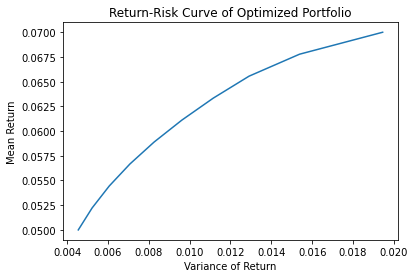

In [353]:
mean = np.array([elem[1] for elem in portfolios])
variance = np.array([elem[2] for elem in portfolios])

plt.plot(variance, mean)
plt.ylabel('Mean Return')
plt.xlabel('Variance of Return')
plt.title('Return-Risk Curve of Optimized Portfolio')

この曲線からは期待収益をどのような値に選べばよいか判断できないため、平均値 - n * σ の点をプロットします。

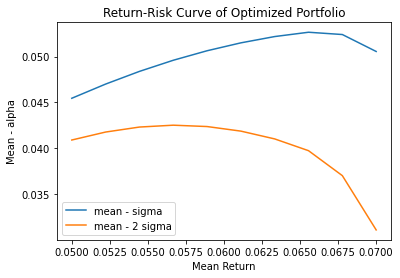

In [352]:
plt.plot(y_1, y_1 - y_2, label='mean - sigma')
plt.plot(y_1, y_1 - y_2 * 2, label='mean - 2 sigma')

plt.xlabel('Mean Return')
plt.ylabel('Mean - alpha')
plt.title('Return-Risk Curve of Optimized Portfolio')
plt.legend()

このプロットから、以下のことがわかります。
* 期待収益を 5.5% あたりにとれば、平均値 - 2σ の点のリターンが 4.2% となる（仮に分布が正規分布だとすると、97.5% の確率でこれ以上のリターンが見込むことができる）
* 期待収益を 6.5% あたりにとれば、平均値 - σ の点のリターンが 5.2% となる（仮に分布が正規分布だとすると、 84% の確率でこれ以上のリターンが見込むことができる）

このように、収益の信頼区間を保証しながら、リターンの期待値を大きくとる方針を立てることができました。

# まとめ：ポートフォリオの組み方について

このnotebookでは、静的な統計解析の結果から良いポートフォリオを組む方針について考察しました。
具体的には、以下について言及しました。

* 銘柄を選ぶときは、リスクが同じだと、リターンが大きくなるように選ぶ
* なるべく銘柄どうしの相関が小さくなるように選ぶほうがリスクが小さくなる（共倒れしにくくなる）
* マコービッツの平均分散モデルによって、期待収益を満たす最小リスクの銘柄選択を示した

以下については触れませんでした。

* モデルを使って予測した結果をポートフォリオに反映する方針について